# Предсказание коэффициента восстановления золота из золотосодержащей руды.

**Описание данных:**

Возможные значения для блока [этап]:
* **rougher** — флотация
* **primary_cleaner** — первичная очистка
* **secondary_cleaner** — вторичная очистка
* **final** — финальные характеристики

Возможные значения для блока [тип_параметра]:
* **input** — параметры сырья
* **output** — параметры продукта
* **state** — параметры, характеризующие текущее состояние этапа
* **calculation** — расчётные характеристики

<div style="border:solid #8A2BE2 2px; padding: 40px">

**Цель исследования**
    
Создание прототипа модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды.
    
**Ход исследования**

* Загрузка и подготовка данных.
* Проведение исследовательского анализа данных
* Обучение разных моделей и поиск лучшей.
* Проведение финального тестирования.

## 1.Подготовка данных

In [203]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.decomposition import PCA

from tqdm import tqdm


### 1.1. Обзор данных

In [147]:
try:
    train_data=pd.read_csv('gold_recovery_train_new.csv')
    test_data=pd.read_csv('gold_recovery_test_new.csv')
    full_data=pd.read_csv('gold_recovery_full_new.csv')
except:
    train_data=pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test_data=pd.read_csv('/datasets/gold_recovery_test_new.csv')
    full_data=pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [148]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


### 1.2. Функция эффективности обогащения

In [149]:
C= train_data['rougher.output.concentrate_au']
F= train_data['rougher.input.feed_au']               
T= train_data['rougher.output.tail_au']
output = train_data['rougher.output.recovery']        

recovery = (C*(F-T))/(F*(C-T))*100

print(mean_absolute_error(output, recovery))

9.73512347450521e-15


Значение средего абсолютного отклонения между рассчитанной и заданной функцией обогащения близко к нулю, что означает, что заданная функция расчитана верно.

### 1.3. Анализ признаков в тестовой выборке. 

In [150]:
features_difference=[]
for x in train_data.columns:
    if x not in test_data.columns:
        features_difference.append(x)

for x in features_difference:
    print(x,'\n')

final.output.concentrate_ag 

final.output.concentrate_pb 

final.output.concentrate_sol 

final.output.concentrate_au 

final.output.recovery 

final.output.tail_ag 

final.output.tail_pb 

final.output.tail_sol 

final.output.tail_au 

primary_cleaner.output.concentrate_ag 

primary_cleaner.output.concentrate_pb 

primary_cleaner.output.concentrate_sol 

primary_cleaner.output.concentrate_au 

primary_cleaner.output.tail_ag 

primary_cleaner.output.tail_pb 

primary_cleaner.output.tail_sol 

primary_cleaner.output.tail_au 

rougher.calculation.sulfate_to_au_concentrate 

rougher.calculation.floatbank10_sulfate_to_au_feed 

rougher.calculation.floatbank11_sulfate_to_au_feed 

rougher.calculation.au_pb_ratio 

rougher.output.concentrate_ag 

rougher.output.concentrate_pb 

rougher.output.concentrate_sol 

rougher.output.concentrate_au 

rougher.output.recovery 

rougher.output.tail_ag 

rougher.output.tail_pb 

rougher.output.tail_sol 

rougher.output.tail_au 

secondary_cleaner.output

В тестовой выборке отсутствуют результаты, которые могут быть получены в ходе проведения всех фаз обработки руды. Таким образом данные из тестовой выборке соответсвуют начальному этапу обработки, как если бы нам только предстояло ее провести.

### 1.4. Предобработка данных

#### 1.4.1. Проверка пропусков в данных

In [151]:
train_data=train_data.ffill()
test_data=test_data.ffill()
print('NaN values per columns after:','\n',train_data.isna().sum().values)
print('NaN values per columns after:','\n',test_data.isna().sum().values)

NaN values per columns after: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
NaN values per columns after: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Поскольку соседние по времени параметры часто похожи, заменим пропуски данными из соседних по времени объектов.

#### 1.4.2. Проверка наличия дубликатов

In [152]:
print(test_data.duplicated().sum())
print(train_data.duplicated().sum())

0
0


Явные дубликаты в данных отсутсвуют

#### 1.4.3. Проверка мультиколлинеарности в признаках

In [153]:
def correlation(x):
    return x>=0.75
  
corr_test=test_data.corr()[test_data.corr().apply(correlation)]

corr_filter = (corr_test.notnull().sum()>1).values
col= corr_test.columns
col= col[corr_filter]

new_test_data=test_data[col]

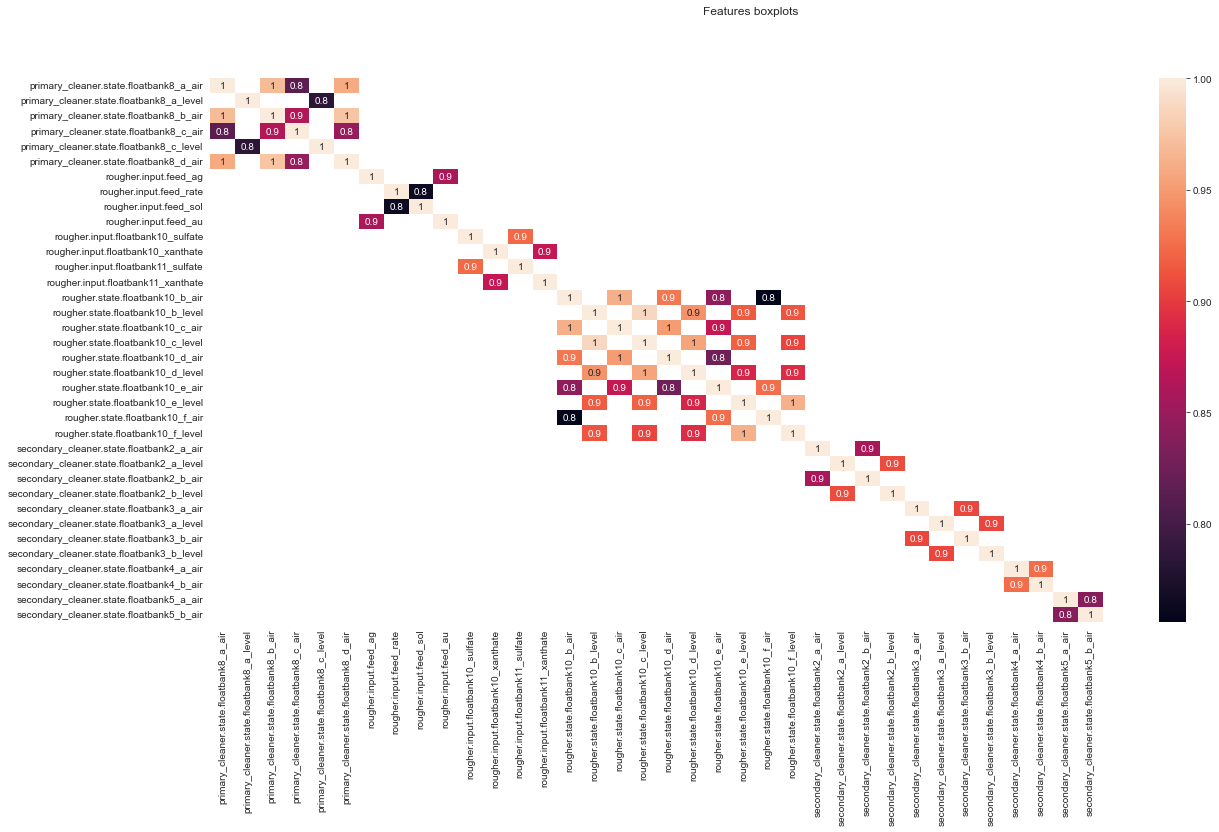

In [154]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20,10))
fig.suptitle('Features boxplots')

sns.heatmap(new_test_data.corr()[new_test_data.corr().apply(correlation)], annot=True, fmt='.1g')
plt.show()

В качестве проверки мультиколлинеарности признаков будем учитывать только признаки, в тестовой выборке. Т.к. именно по ним нам предстоит обучать модель. Как видим, часть признаков обладает высокой коллинеарностью, однако удалять их мы не будем, т.к. в дальнейшем будут использованы методы, которые успешно работают с мультиколлинеарными признаками.

<div style="border:solid #4F6272 1px; padding: 4px">
    
По итогу раздела был осуществлен обзор датафрейма, проверено соответствие заданных значений функции обогащения, проведена предобработка данных. Найденные пропуски были заполнены, произведена проверка на наличие дубликатов, признаки проверены на мультиколлинеарность. Данные не проверены на выбросы, т.к. заданные признаки требуют экспертной оценки.

## 2. Исследовательский анализ данных

### 2.1 Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки.


In [155]:
metall_phases={'au':[],'ag':[],'pb':[]}

for x in metall_phases.keys():
    for column in train_data.columns:
        if ((x in column[-2:]) and ('tail' not in column)):
            metall_phases[x].append(column)          
for x in metall_phases.keys():
    metall_phases[x]=[metall_phases[x][2],metall_phases[x][3],metall_phases[x][1],metall_phases[x][0]]
    
print(metall_phases)

{'au': ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], 'ag': ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], 'pb': ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']}


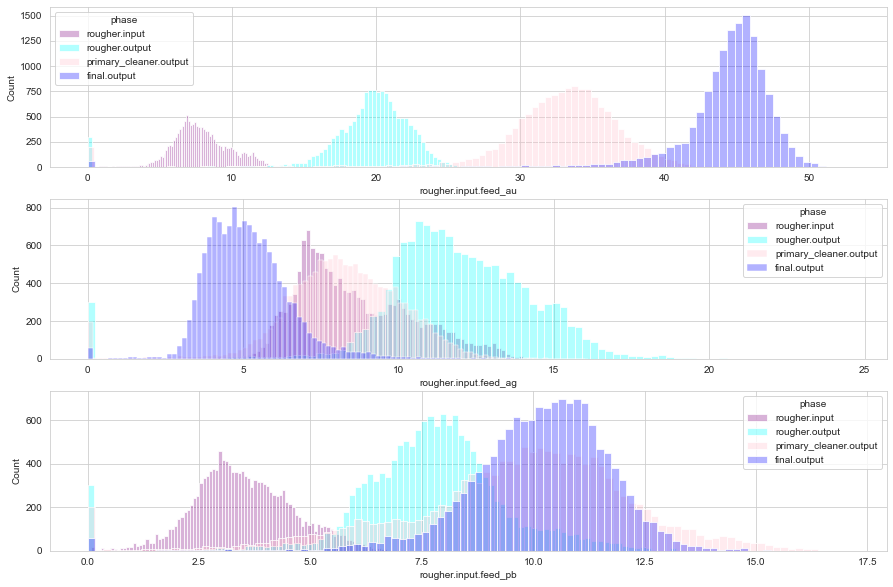

In [156]:
fig, axs = plt.subplots(3,1, figsize=(15,10))
colors = ['purple','cyan','pink','blue']
sns.set_style("whitegrid")
j=0
for metall in metall_phases.keys():
    i=0
    for phase in metall_phases[metall]:
        sns.histplot(data=train_data[phase],ax=axs[j],color=colors[i], alpha  = 0.3, bins=100)
        axs[j].legend( ['rougher.input', 'rougher.output','primary_cleaner.output','final.output'], title='phase')
        i+=1
    j+=1
plt.show()

На каждом графике в различных фазах видны пики на значении концентрации веществ равном 0. Эти данные выглядят как аномалии, перед применением модели их следует удалить.

In [157]:
print('Размер тренировочной выборки до:',train_data.shape)
for phase in metall_phases.values():
    for x in phase:
        train_data = train_data[train_data[x]>0]
print('Размер тренировочной выборки после:',train_data.shape)


Размер тренировочной выборки до: (14149, 87)
Размер тренировочной выборки после: (13720, 87)


Концентрация Au увеличивается на протяжении всей стадии очистки. Концентрация Ag снижается к финальной стадии, а концентрация Pb возрастает и сохраняется на последних двух фазах. 

Обнаруженные нулевые аномальные значения удалены, что привело к снижению размера данных на 4%.


### 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

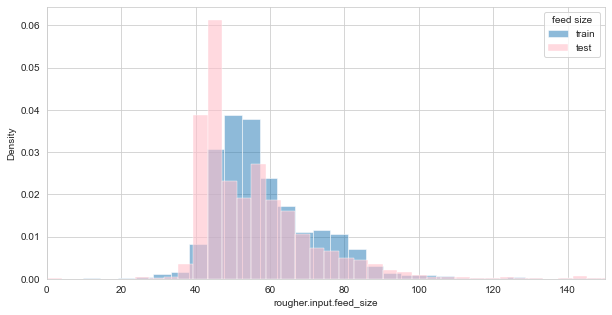

In [158]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

sns.histplot(data=train_data['rougher.input.feed_size'], bins=100, alpha  = 0.5, stat='density', common_norm=False)
sns.histplot(data=test_data['rougher.input.feed_size'], color='pink', bins=100,alpha  = 0.6, stat='density', common_norm=False)    
axs.set_xlim(0,150)

axs.legend( ['train', 'test'], title='feed size')
plt.show()
plt.show()

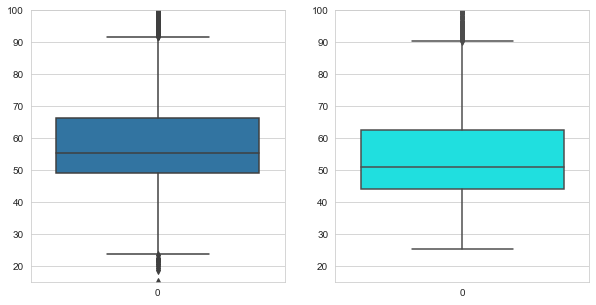

In [159]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(data=train_data['rougher.input.feed_size'], ax=axs[0])
sns.boxplot(data=test_data['rougher.input.feed_size'], ax=axs[1], color='cyan') 
axs[0].set_ylim(15,100)
axs[1].set_ylim(15,100)
plt.show()

In [160]:
print(train_data['rougher.input.feed_size'].median()-test_data['rougher.input.feed_size'].median())

4.547909473766843


Размер гранул в тренировочных и тестовых данных имеет схожее распределение. Медиана тестовых данных смещена относительно тренировочных на 4.53.


### 2.3. Исследование суммарной концентрации всех веществ на разных стадиях.

In [161]:
phases=['rougher.input', 'rougher.output','primary_cleaner.output','final.output']

def plot_concentration(data):
    summary=pd.DataFrame(columns=phases)
    
    for index in range(4):
        sum_on_phase=0
        for metall in metall_phases.keys():
            sum_on_phase+=data[metall_phases[metall][index]]
        summary[phases[index]]=sum_on_phase

    fig, axs = plt.subplots(2,2, figsize=(20,10))
    i=0
    j=0
    k=0
    
    for phase in phases:
        axs[i][j].set_title('Концентрация веществ на стадии '+ str(phases[k]), fontsize=14)
        sns.histplot(data=summary[phase], ax=axs[i][j], bins=60, alpha  = 0.4, color='blue')
        j+=1
        k+=1
        if j>1:
            i+=1
            j=0
    return summary

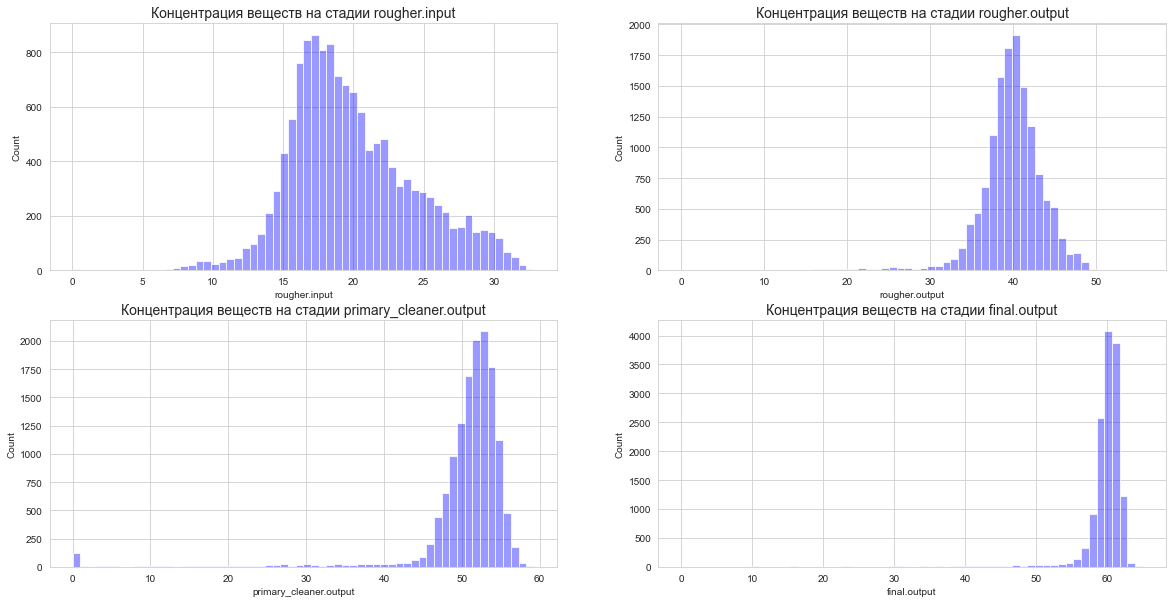

In [162]:
summary = plot_concentration(train_data)

In [163]:
print(summary['final.output'].median())
print(summary['rougher.input'].var () - summary['final.output'].var())

60.24693874888653
2.3858297096035628


С продвижением по фазам очистки суммарная концентрация веществ возрастает, дисперсия распределения снижается на 3.25. На финальной стадии медианное значение концентрации порядка 60.

<div style="border:solid #4F6272 1px; padding: 4px">
    
По итогу раздела была проведена оценка изменения концентрации металлов на протяжении всех фаз очистки, произведено сравнение распределений размеров гранул сырья в тренировочных и тестовых данных, а также исследовано поведение распределения суммарной концентрации веществ на каждой фазе.

## 3. Построение модели

### 3.1. Функция для вычисления итоговой sMAPE.

In [164]:
def smape(target,predictions):
    smape = 100*(2*abs(target-predictions)) / (abs(target)+abs(predictions))
    return sum(smape) / len(smape)

In [165]:
def final_smape(r,f):
    return(0.25*r+0.75*f)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> `smape` и `final_smape` расчитаны верно.</font>

In [166]:
def smape_scorer(model, X, y):
    return smape(y, model.predict(X))

In [187]:
def neg_smape_scorer(model, X, y):
    return (-1)*smape(y, model.predict(X))

### 3.2. Обучение моделей и оценка их качества.

#### 3.2.1. Разделение данных

In [168]:
r_columns =[[],[]]
for x in test_data.columns:
    if x!='date':
        r_columns[1].append(x)
        if 'rougher' in x:
            r_columns[0].append(x)
    
new_full_data=full_data.loc[:,['date','rougher.output.concentrate_au', 'final.output.concentrate_au']]
test_data=test_data.merge(new_full_data, how='inner', on='date')
test_data=test_data.drop(columns=['date'])

In [169]:
r_train_features=train_data[r_columns[0]]
r_train_target= train_data['rougher.output.concentrate_au']

f_train_features=train_data[r_columns[1]]
f_train_target=train_data['final.output.concentrate_au']

r_test_features=test_data[r_columns[0]]
r_test_target=test_data['rougher.output.concentrate_au']

f_test_features=test_data[r_columns[1]]
f_test_target=test_data['final.output.concentrate_au']

Данные разделены на тренировочну и тестовые выборки. Данные целевых значений в тестовых данных получены из таблицы full_data.

#### 3.2.2. Маштабирование признаков

In [170]:
scaler = StandardScaler()

scaler.fit(r_train_features)    
r_train_features=scaler.transform(r_train_features)
r_test_features=scaler.transform(r_test_features)

scaler.fit(f_train_features) 
f_train_features=scaler.transform(f_train_features)
f_test_features=scaler.transform(f_test_features)

Данные всех выборок отмаштабированы при помощи StandartScaler.

#### 3.2.3. RidgeCV Regression model

**Без применения метода главных компонент**

In [176]:
from sklearn.linear_model import RidgeCV
model = RidgeCV(alphas=[0.001,0.01,1,10])

model.fit(r_train_features,r_train_target)
print('Для фазы флотации')
print('Наилучшее значение sMAPE на тренировочной выборке:', np.mean(cross_val_score(model, r_train_features,r_train_target, scoring=smape_scorer, cv=5)))
#print('Наилучшее значение sMAPE на валидационной выборке:', smape_scorer(model,r_valid_features,r_valid_target),'\n')

model.fit(f_train_features,f_train_target)
print('Для финальной фазы')
print('Наилучшее значение sMAPE на тренировочной выборке:', np.mean(cross_val_score(model, f_train_features,f_train_target, scoring=smape_scorer, cv=5)))
#print('Наилучшее значение sMAPE на валидационной выборке:', smape_scorer(model, f_valid_features,f_valid_target))


Для фазы флотации
Наилучшее значение sMAPE на тренировочной выборке: 7.885848898787867
Для финальной фазы
Наилучшее значение sMAPE на тренировочной выборке: 6.598495345986426


**С применением метода главных компонент**

In [172]:
pca = PCA()
r_pca_train_features= pca.fit_transform(r_train_features)
r_explained_variance = pca.explained_variance_ratio_

f_pca_train_features= pca.fit_transform(f_train_features)
f_explained_variance = pca.explained_variance_ratio_

In [173]:
def pca_plot(train_features, train_target, k):

    score_list=[]
    for n in tqdm(range(1,k)):
        model = RidgeCV(alphas=[0.01], scoring=neg_smape_scorer, cv=5)
        pca = PCA(n_components=n)
        
        pca_train_features=pca.fit_transform(train_features)
        model.fit(pca_train_features, train_target)
        score_list.append(np.mean(cross_val_score(model, pca_train_features, train_target, scoring=smape_scorer, cv=5)))
    
    fig, axs = plt.subplots(1,1, figsize=(10,4))
    fig.suptitle('Зависимость sMAPE от количества признаков',fontsize=14)
    axs.scatter(x=range(1,k), y=score_list)
    
    val, idx = min((val, idx) for (idx, val) in enumerate(score_list))
    plt.show()

    print('Наилучшее значение sMAPE на тренировочной выборке:', val, ', при количестве признаков:', idx+1)

100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


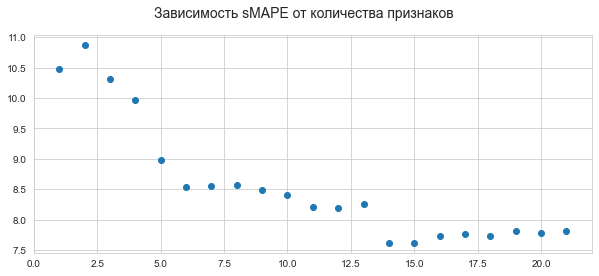

Наилучшее значение sMAPE на тренировочной выборке: 7.61819471130967 , при количестве признаков: 15


In [174]:
pca_plot(r_train_features, r_train_target, len(r_explained_variance))

100%|██████████| 51/51 [00:12<00:00,  4.10it/s]


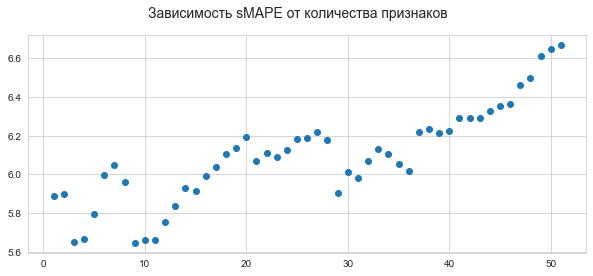

Наилучшее значение sMAPE на тренировочной выборке: 5.646381199754047 , при количестве признаков: 9


In [175]:
pca_plot(f_train_features,f_train_target, len(f_explained_variance))

Модель RidgeCV Regression применена к полному перечню маштабированных признаков и к отобранному при помощи метода главных компонент набору наиболее важных признаков. Приведены визуализации, показывающие, как количество рассматриваемых признаков влияет на качество модели. Применение метода главных компонент дает наилучшее значение sMAPE на валидационной выборке:
* для фазы флотации:  **7.61**
* для финальной фазы: **5.64**

#### 3.2.3. Модель дерева решений и случайного леса

In [190]:
models=[DecisionTreeRegressor(), RandomForestRegressor(random_state=12345)]
grid = [{'max_depth': range(1,10)},{'n_estimators': range (10, 51, 10),'max_depth': range (1,5)}]

In [192]:
def apply_gridsearch_cv(models,grid,train_f, train_t):
    best_params=[]
    score_list=[]
 
    for i in  range(len(models)):
        grid_cv = GridSearchCV(estimator=models[i], param_grid = grid[i] ,scoring=neg_smape_scorer,cv = 5)
        grid_cv.fit(train_f, train_t)
        
        print("best model:",grid_cv.best_estimator_)
        
        train_score = smape_scorer(grid_cv.best_estimator_, train_f, train_t)

        print('Наилучшее значение sMAPE на тренировочной выборке:', train_score)
        print("\n")
        
        best_params.append(grid_cv.best_params_)
        score_list.append((-1)*np.mean(train_score))

    return (best_params, score_list)

**Для стадии флотации**

In [193]:
apply_gridsearch_cv(models, grid, r_train_features, r_train_target)

best model: DecisionTreeRegressor(max_depth=4)
Наилучшее значение sMAPE на тренировочной выборке: 7.000015724637915


best model: RandomForestRegressor(max_depth=4, n_estimators=20, random_state=12345)
Наилучшее значение sMAPE на тренировочной выборке: 6.637536857299629




([{'max_depth': 4}, {'max_depth': 4, 'n_estimators': 20}],
 [-7.000015724637915, -6.637536857299629])

In [194]:
model=RandomForestRegressor(max_depth= 4, n_estimators= 20, random_state=12345)

def importance_plot(model, train_features, train_target,i):
    model.fit(train_features,train_target)

    importance = model.feature_importances_
    x=r_columns[i]
    fig, ax = plt.subplots(1, 1, figsize=(15,10))

    width = 0.75  
    ind = np.arange(len(importance))
    ax.set_yticks(ind + width/10)
    ax.set_yticklabels(x, minor=False)
    ax.set_xlim(0,max(importance)+max(importance)*0.25)
    ax.barh([x for x in range(len(importance))], importance,width,color="pink" )

    for i, v in enumerate(importance):
        ax.text( v, i-width/3, str(np.round(float(v),3)), color='black')
    
    plt.title('Feature Importance')
    plt.xlabel('importance')
    plt.show()

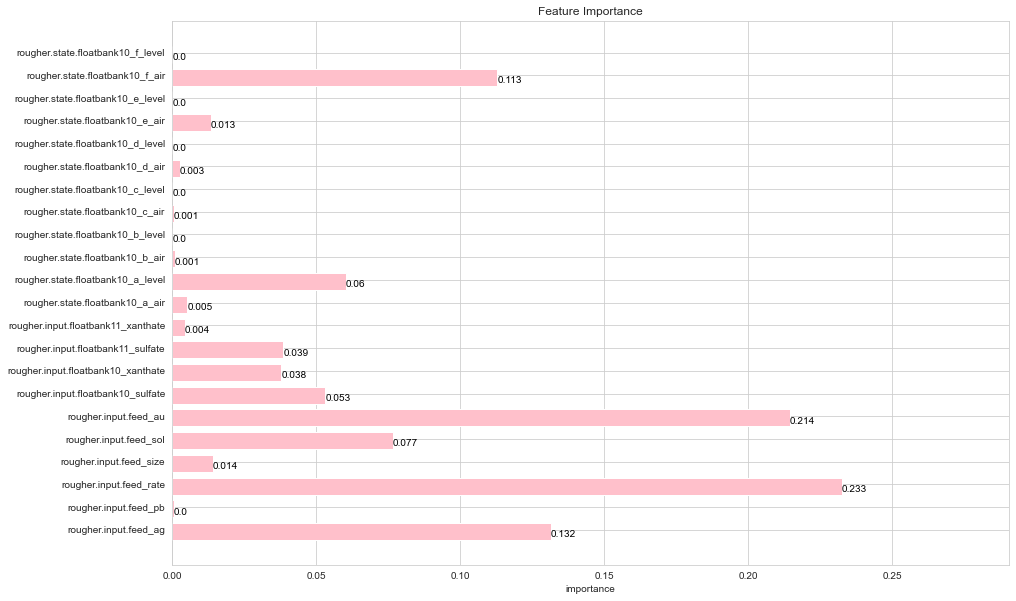

In [195]:
importance_plot(model, r_train_features,r_train_target,0)

При подборе гиперпараметров при помощи GridSeachCV было получено, что лучшее значение sMAPE на валидационной выборке на стадии **флотации** имеет модель **RandomForestRegressor(max_depth= 4, n_estimators= 20, random_state=12345)**. Также визуализированные наиболее важные признаки для данной модели.
* Значение sMAPE составляет: **6.63**

**Для финальной стадии**

In [196]:
apply_gridsearch_cv(models, grid, f_train_features, f_train_target)

best model: DecisionTreeRegressor(max_depth=2)
Наилучшее значение sMAPE на тренировочной выборке: 5.334102446885163


best model: RandomForestRegressor(max_depth=1, n_estimators=50, random_state=12345)
Наилучшее значение sMAPE на тренировочной выборке: 5.428284365788669




([{'max_depth': 2}, {'max_depth': 1, 'n_estimators': 50}],
 [-5.334102446885163, -5.428284365788669])

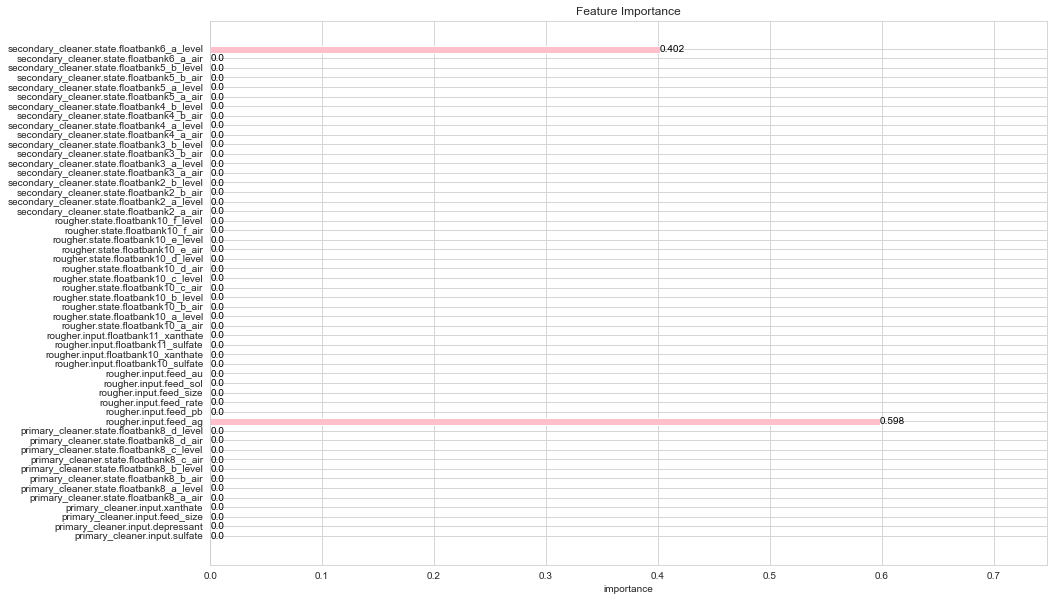

In [197]:
model=DecisionTreeRegressor(max_depth=2)
importance_plot(model, f_train_features, f_train_target,1)


При подборе гиперпараметров при помощи GridSeachCV было получено, что лучшее значение sMAPE на валидационной выборке на **финальной** стадии имеет модель **DecisionTreeRegressor(max_depth=2)**. Также визуализированные наиболее важные признаки для данной модели.
* Значение sMAPE составляет: **5.33**

<div style="border:solid #4F6272 1px; padding: 4px">
    
По итогу раздела был обучен ряд моделей, основанных на алгоритмах **RidgeCV, DecisionTreeRegressor, RandomForestRegressor**.

Лучшая модель на стадии флотациии:
* RandomForestRegressor(max_depth= 4, n_estimators= 20)
    
Лучшая модель на финальной стадии:
* DecisionTreeRegressor(max_depth=2)
    

## 4. Проведение финального тестирования.

In [198]:
r_best_model=RandomForestRegressor(max_depth= 4, n_estimators= 20, random_state=12345)
f_best_model=DecisionTreeRegressor(max_depth=2)


**Для стадии флотации**

Лучшая модель

In [215]:
r_best_model.fit(r_train_features, r_train_target)
r_best_score=smape_scorer(r_best_model, r_test_features, r_test_target)
print('Значение sMAPE на тестовой выборке:', r_best_score)

Значение sMAPE на тестовой выборке: 11.603767565678204


Константная модель

In [216]:
r_dummy_model = DummyRegressor()

r_dummy_model.fit(r_train_features, r_train_target)
r_dummy_score=smape_scorer(r_dummy_model, r_test_features, r_test_target)
print('Значение sMAPE на тестовой выборке:', r_dummy_score)

Значение sMAPE на тестовой выборке: 12.866709278164782


**Для финальной стадии**

In [217]:
f_best_model.fit(f_train_features, f_train_target)
f_best_score=smape_scorer(f_best_model, f_test_features, f_test_target)
print('Значение sMAPE на тестовой выборке:', f_best_score)

Значение sMAPE на тестовой выборке: 7.3624200388830525


In [218]:
f_dummy_model = DummyRegressor()

f_dummy_model.fit(f_train_features, f_train_target)
f_dummy_score=smape_scorer(f_dummy_model, f_test_features, f_test_target)
print('Значение sMAPE на тестовой выборке:', f_dummy_score)

Значение sMAPE на тестовой выборке: 7.475476913436475


**Итоговое значение sMAPE**

In [202]:
print('Итоговое sMAPE наилучших моделей на тестовой выборке:', final_smape(r_best_score,f_best_score))

Итоговое sMAPE на тестовой выборке: 8.422756920581858


In [219]:
print('Итоговое sMAPE константных моделей на тестовой выборке:', final_smape(r_dummy_score,f_dummy_score))

Итоговое sMAPE константных моделей на тестовой выборке: 8.823285004618553


<div style="border:solid #4F6272 1px; padding: 4px">
    
По итогу раздела при применении лучших моделей для стадий флотации и финальной стадии получено итоговое значение sMAPE на тестовой выборке, равное **8.42**, что показывает чуть лучший результат в сравнении с константной моделью.

## 5. Выводы.

<div style="border:solid #8A2BE2 2px; padding: 40px">
    
Задачей исследования было построение  машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды. В качестве метрики качества модели использовалась метрика **final_sMAPE**, которая в свою очередь зависела от sMAPE на стадиях флотации и финальной.

В ходе исследования были изучены предоставленные данные,произведена проверка корректности данных функции обогащения, произведена предобработка данных, включая проверку на пропуски, дубликаты, а также маштабирование признаков.

Произведен исследовательский анализ данных, в ходе которого было исследована концентрация различных металлов на всех фазах очистки. Концентрация **Au увеличивается** на протяжении всех фаз очистки, что означает, что технологический процесс построен верно. Распределение размера гранул вещества на тестовом и тренировочном множестве схожи, что означает объективную оценку модели при применении к обеим выборкам. Также рассмотрено изменение суммарной концентрации веществ от фазы к фазе, полученные данные подтверждают возрастание суммарного количества веществ при достижении финальной тсадии очистки руды.

Были рассмотрены несколько моделей машинного обучения, основанных на алгоритмах **RidgeCV, DecisionTreeRegressor, RandomForestRegressor**. Для алгоритма **RidgeCV** было проверено качество модели на всех параметрах, а также на части параметров, отобранных при помощи метода **PCA**. Для моделей на основе **DecisionTreeRegressor, RandomForestRegressor** были подобранны гиперпараметры при помощи перебора по сетке с использованием кросс-валидации, дающие наилучший результат на валидационном множестве.Для иллюстрации представлен **график важности параметров** для модели **RandomForestRegressor** для каждой из рассматриваемых фаз. Затем модели, проявившая себя лучше всего на валидационном множестве для каждой из стадий были применены к тестовому множеству.
    
****

**RidgeCV**
Модели на основе данного алгоритма показали схожие результаты при применении к общему пулу признаков и при применении к признакам, отобранным при помощи PCA.

**DecisionTreeRegressor**
Модели на основе данного алгоритма показали лучшие результаты для финальной фазы .    
    
**RandomForestRegressor**
Модель на основе данного алгоритма позволила визуализировать значимость различных признаков для модели на фазе флотации.    


*Наилучшая модель для стадии флотации:*
* sMAPE на валидационной выборке: **6.63**
* sMAPE на тестовой выборке:: **11.60**

*Наилучшая модель для финальной стадии:*
* sMAPE на валидационной выборке: **5.33**
* sMAPE на тестовой выборке:: **7.36**    

Видно, что рост sMAPE на стадии флотации при переходе от валидационной к тестовой выборке значительный, что означает сильную переобученность используемой модели.
    
**Применение к тестовой выборке** 
    
В ходе применения **наилучших** полученных моделей к тестовой выборке было получено итоговое значение **finat_sMApe**, равное 9.15 

__________________________
Рекомендации: Для подбора модели с более высоким качеством имеет смысл рассмотреть также модели на основе градиентного бустинга или нейронных сетей.